# 日历效果策略


In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


工具方法

In [2]:
def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标
    """

    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])

        return res

    ret = adjnav.pct_change()
    annret = np.nanmean(ret) * 242
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]


def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()


def date_count_in_month(dates):
    # 计算日期序列中每个日期在所在月中的序数
    cur_count = 1
    counts = [cur_count]
    for i in range(1, len(dates)):
        if dates[i].month == dates[i - 1].month:
            cur_count = cur_count + 1
        else:
            cur_count = 1
        counts.append(cur_count)
    return counts


加载数据

In [3]:
index_data = pd.read_csv('res/指数历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

回测

In [4]:
# 设置回测参数

# 回测起止日期
start_date = datetime.date(2022, 1, 1)
end_date = datetime.date(2022, 12, 31)
# 每月持仓交易起始日、截止日。从1起
t1 = 1
t2 = 5
# 交易手续费
fee_rate_fund = 0.0015
fee_rate_stock = 0.00025

         AnnRet    AnnVol        SR     MaxDD    Calmar
index -0.198101  0.202669 -0.977459 -0.279249 -0.709404
stgy   0.039616  0.104706  0.378358 -0.119757  0.330807


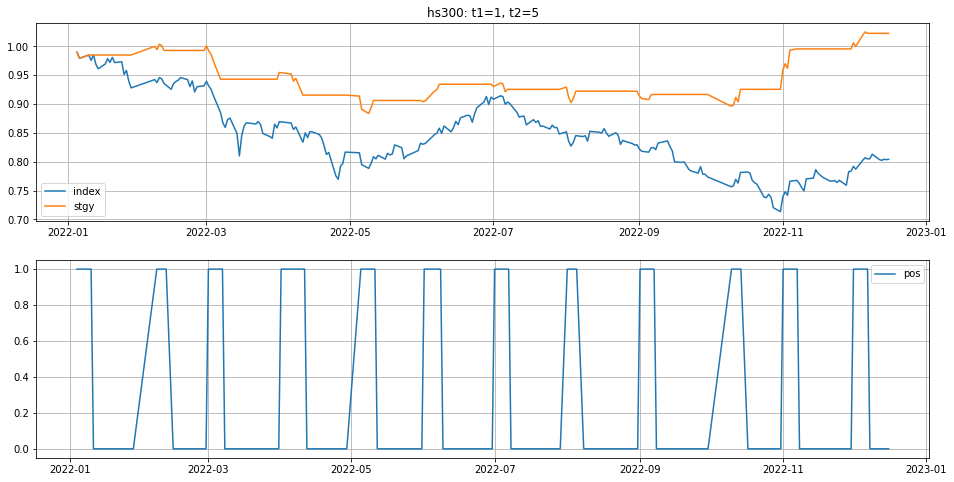

In [5]:
# 标的指数：'hs300' or 'csi500' or 'csi1000'
index_id = 'hs300'

df = index_data.loc[start_date:end_date, [index_id]]
df.fillna(0, inplace=True)
df['index_ret'] = df[index_id].pct_change()
df['index'] = (1 + df['index_ret']).cumprod()
df['date_count_in_month'] = date_count_in_month(df.index)
df['pos'] = [1 if (e >= t1 and e <= t2) else 0 for e in df['date_count_in_month']]
# df['pos']= df.pos.shift(-1, fill_value=0)
df['stgy_ret'] = df['pos'] * df['index_ret']
charge_row = df[df['date_count_in_month'] == 1].index
df.loc[charge_row, 'stgy_ret'] = df.loc[charge_row, 'stgy_ret'] - fee_rate_stock
df['stgy'] = (1 + df['stgy_ret']).cumprod()

# 回测结果展示
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 1, 1)
df.loc[:, ['index', 'stgy']].plot(ax=ax1, grid=True, title='%s: t1=%d, t2=%d' % (index_id, t1, t2))
ax2 = fig.add_subplot(2, 1, 2)
df.loc[:, ['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:, ['index', 'stgy']])
print(res)

In [6]:
df.head()

,hs300,index_ret,index,date_count_in_month,pos,stgy_ret,stgy
2022-01-04,4917.77,NaN,NaN,1,1,NaN,NaN
2022-01-05,4868.12,-0.010096,0.989904,2,1,-0.010096,0.989904
2022-01-06,4818.23,-0.010248,0.979759,3,1,-0.010248,0.979759
2022-01-07,4822.37,0.000859,0.980601,4,1,0.000859,0.980601
2022-01-10,4844.05,0.004496,0.985009,5,1,0.004496,0.985009


         AnnRet    AnnVol        SR     MaxDD   Calmar
index -0.158747  0.216449 -0.733413 -0.276067 -0.57503
stgy   0.130264  0.096161  1.354641 -0.097973  1.32959


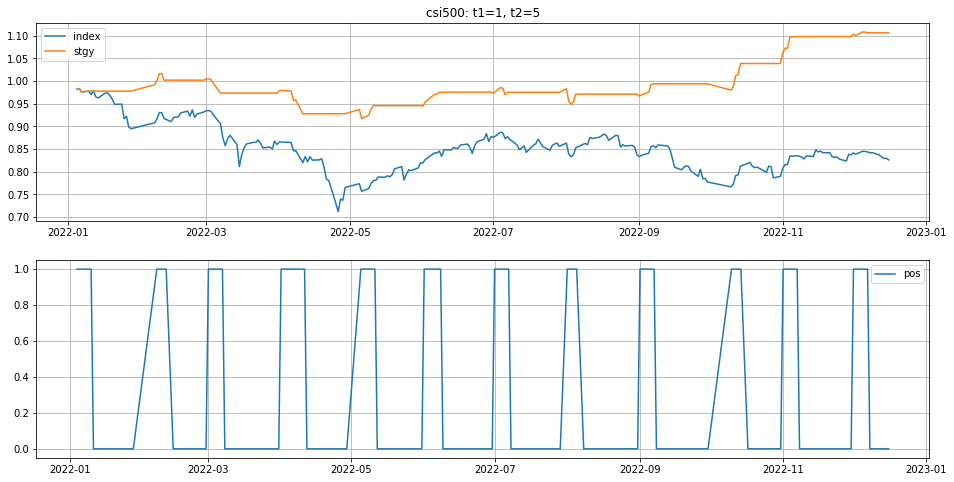

In [7]:
# 设置回测参数
index_id = 'csi500'

df = index_data.loc[start_date:end_date, [index_id]]
df['index_ret'] = df[index_id].pct_change()
df['index'] = (1 + df['index_ret']).cumprod()
df['date_count_in_month'] = date_count_in_month(df.index)
df['pos'] = [1 if (e >= t1 and e <= t2) else 0 for e in df['date_count_in_month']]
df['stgy_ret'] = df['pos'] * df['index_ret']
charge_row = df[df['date_count_in_month'] == 1].index
df.loc[charge_row, 'stgy_ret'] = df.loc[charge_row, 'stgy_ret'] - fee_rate_stock
df['stgy'] = (1 + df['stgy_ret']).cumprod()

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 1, 1)
df.loc[:, ['index', 'stgy']].plot(ax=ax1, grid=True, title='%s: t1=%d, t2=%d' % (index_id, t1, t2))
ax2 = fig.add_subplot(2, 1, 2)
df.loc[:, ['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:, ['index', 'stgy']])
print(res)

         AnnRet    AnnVol        SR     MaxDD    Calmar
index -0.154657  0.249849 -0.619002 -0.328633 -0.470606
stgy   0.145049  0.111266  1.303624 -0.130048  1.115349


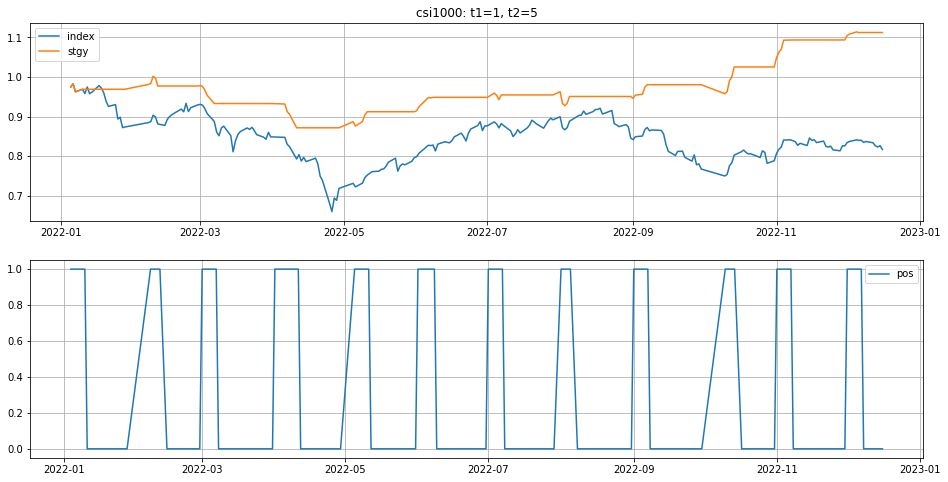

In [8]:
# 设置回测参数
index_id = 'csi1000'

df = index_data.loc[start_date:end_date, [index_id]]
df['index_ret'] = df[index_id].pct_change()
df['index'] = (1 + df['index_ret']).cumprod()
df['date_count_in_month'] = date_count_in_month(df.index)
df['pos'] = [1 if (e >= t1 and e <= t2) else 0 for e in df['date_count_in_month']]
df['stgy_ret'] = df['pos'] * df['index_ret']
charge_row = df[df['date_count_in_month'] == 1].index
df.loc[charge_row, 'stgy_ret'] = df.loc[charge_row, 'stgy_ret'] - fee_rate_stock
df['stgy'] = (1 + df['stgy_ret']).cumprod()

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 1, 1)
df.loc[:, ['index', 'stgy']].plot(ax=ax1, grid=True, title='%s: t1=%d, t2=%d' % (index_id, t1, t2))
ax2 = fig.add_subplot(2, 1, 2)
df.loc[:, ['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:, ['index', 'stgy']])
print(res)

In [9]:
index_data = pd.read_csv('res/富国500ETF.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

In [10]:
# 设置回测参数

# 回测起止日期
start_date = datetime.date(2022, 1, 1)
end_date = datetime.date(2022, 12, 31)
# 每月持仓交易起始日、截止日。从1起
t1 = 1
t2 = 5

         AnnRet   AnnVol        SR     MaxDD    Calmar
index -0.091856  0.17155 -0.535448 -0.195951 -0.468772
stgy   0.117213  0.07585  1.545324 -0.075282  1.556996


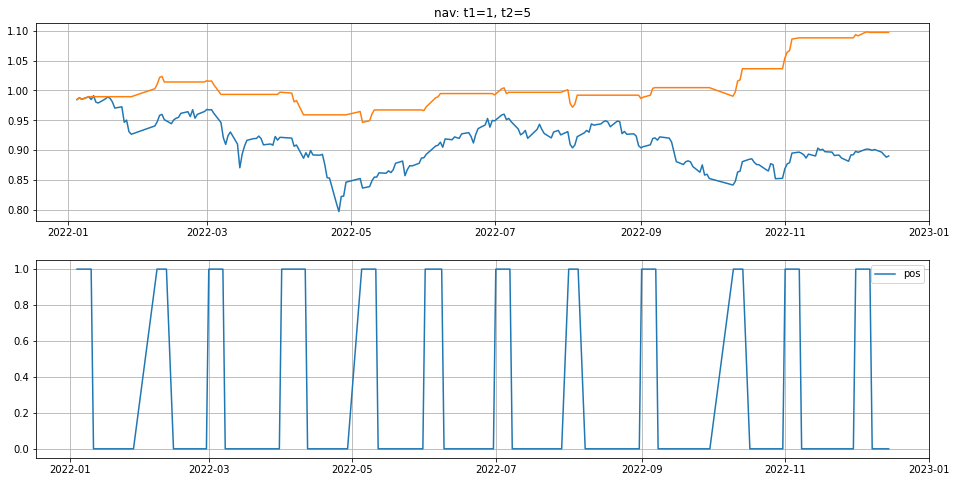

In [11]:
index_id = 'nav'

df = index_data.loc[start_date:end_date, [index_id]]
df['index_ret'] = df[index_id].pct_change()
df['index'] = (1 + df['index_ret']).cumprod()
df['date_count_in_month'] = date_count_in_month(df.index)
df['pos'] = [1 if (e >= t1 and e <= t2) else 0 for e in df['date_count_in_month']]
# df['pos']= df.pos.shift(-1, fill_value=0)
df['stgy_ret'] = df['pos'] * df['index_ret']
charge_row = df[df['date_count_in_month'] == 1].index
df.loc[charge_row, 'stgy_ret'] = df.loc[charge_row, 'stgy_ret'] - fee_rate_fund
df['stgy'] = (1 + df['stgy_ret']).cumprod()
# df.head()

# 回测结果展示
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 1, 1)
df.loc[:, ['index', 'stgy']].plot(ax=ax1, grid=True, title='%s: t1=%d, t2=%d' % (index_id, t1, t2), legend=False)
ax2 = fig.add_subplot(2, 1, 2)
df.loc[:, ['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:, ['index', 'stgy']])
print(res)

In [ ]:
df.iloc[55:110]